### Importing the libraries

In [101]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from sklearn.metrics.pairwise import haversine_distances
%matplotlib inline
import plotly.express as px
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster

plt.style.use('seaborn-whitegrid')

In [102]:
nyc = pd.read_csv('train.csv', nrows = 500000,parse_dates=["pickup_datetime"])

# Let's see data of first few rows of the dataset
nyc.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45+00:00,-74.000964,40.731630,-73.972892,40.758233,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00+00:00,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00+00:00,-73.951300,40.774138,-73.990095,40.751048,1
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00+00:00,-74.006462,40.726713,-73.993078,40.731628,1
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00+00:00,-73.980658,40.733873,-73.991540,40.758138,2


## Data Exploration

### Dataset using : nyc.csv

#### Checking the datatypes of the features of the dataset

In [103]:
nyc.dtypes

key                               object
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

#### Checking the statistics of the data

In [104]:
nyc.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,500000.000000,500000.000000,500000.000000,499995.000000,499995.000000,500000.000000
mean,11.358361,-72.519958,39.920276,-72.522435,39.916526,1.683428
std,9.916617,11.856831,8.073475,11.797362,7.391002,1.307395
min,-44.900000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,0.000000
25%,6.000000,-73.992047,40.734917,-73.991382,40.734057,1.000000
50%,8.500000,-73.981785,40.752670,-73.980126,40.753152,1.000000
75%,12.500000,-73.967117,40.767076,-73.963572,40.768135,2.000000
max,500.000000,2140.601160,1703.092772,40.851027,404.616667,6.000000


### From the statistical summary we can conclude these points :
- The fare amount has a minimum value of -44.9, which cannot be true. The base fare for New York City nyc is \\$2.50.So, We will be removing records where the fare is less than \\$2.50.
- The minimum value of passenger count is zero. This is not possible.

In [105]:
nyc = nyc[nyc['fare_amount']>2.50]

In [106]:
nyc = nyc[nyc['passenger_count']>0]

In [107]:
nyc.shape

(496209, 8)

In [108]:
#Now checking for missing data
nyc.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

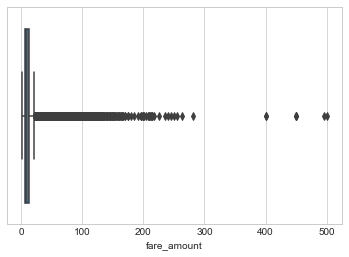

In [109]:
sns.boxplot(nyc['fare_amount'])

From the boxplot we can see that there are a lot of outliers. We will be removing them in the below steps.

In [110]:
# Calculating the mean and the standard deviation of the 'fare_amount' in the dataset.
mean_df = np.mean(nyc.fare_amount)
std_df = np.std(nyc.fare_amount)
# Filtering the rows of from outliers
nyc = nyc[(nyc.fare_amount > (mean_df - 3*std_df)) & (nyc.fare_amount < (mean_df + 3*std_df))]
nyc.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [111]:
nyc.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,482901.000000,482901.000000,482901.000000,482901.000000,482901.000000,482901.000000
mean,10.228548,-72.558902,39.941015,-72.571777,39.944395,1.688566
std,6.468279,11.795630,8.086422,11.656278,7.360102,1.305346
min,2.510000,-2986.242495,-3116.285383,-3383.296608,-2559.748913,1.000000
25%,6.000000,-73.992180,40.735835,-73.991413,40.734877,1.000000
50%,8.100000,-73.981991,40.753030,-73.980293,40.753519,1.000000
75%,12.100000,-73.967957,40.767272,-73.964381,40.768284,2.000000
max,41.100000,2140.601160,1703.092772,40.851027,404.616667,6.000000


### Location Data
New York city coordinates are (https://www.travelmath.com/cities/New+York,+NY):

- longitude = -74.0063889
- lattitude = 40.7141667

We will be deleting all records where these doesn't match up.

In [112]:
nyc = nyc[((nyc['pickup_longitude'] > -78) 
             & (nyc['pickup_longitude'] < -70)) 
            & ((nyc['dropoff_longitude'] > -78) 
               & (nyc['dropoff_longitude'] < -70)) 
            & ((nyc['pickup_latitude'] > 37) 
               & (nyc['pickup_latitude'] < 45)) 
            & ((nyc['dropoff_latitude'] > 37) 
               & (nyc['dropoff_latitude'] < 45))]

In [113]:
nyc.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,473323.000000,473323.000000,473323.000000,473323.000000,473323.000000,473323.000000
mean,10.227409,-73.977504,40.752025,-73.975549,40.752260,1.689073
std,6.467417,0.037583,0.031655,0.037357,0.034899,1.305588
min,2.510000,-77.902484,37.419853,-77.816634,37.346533,1.000000
25%,6.000000,-73.992378,40.737230,-73.991594,40.736557,1.000000
50%,8.100000,-73.982222,40.753727,-73.980720,40.754223,1.000000
75%,12.100000,-73.969102,40.767673,-73.965997,40.768570,2.000000
max,41.100000,-70.257668,43.183332,-70.050500,44.600000,6.000000


In [114]:
nyc.shape

(473323, 8)

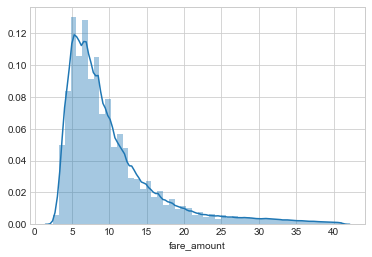

In [115]:
sns.distplot(nyc.fare_amount)

In [116]:
nyc_test = pd.read_csv('test.csv')

In [117]:
nyc_test.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


In [118]:
nyc_test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [119]:
nyc_test.shape

(9914, 7)

#### Calculating the distance

In [120]:
#To calculate the distance in miles we use a formula called "HAVERSINE FORMULA"

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [121]:
#We add a new distance column and from the diagram we can understand that all rides are short distance

nyc['distance'] = distance(nyc.pickup_latitude, nyc.pickup_longitude, \
                                      nyc.dropoff_latitude, nyc.dropoff_longitude)
nyc.distance.describe()

count    473323.000000
mean          1.863457
std           2.042439
min           0.000000
25%           0.775871
50%           1.312661
75%           2.323440
max         263.979057
Name: distance, dtype: float64

#### Adding Year, Month and Day and time as a separate column

In [122]:
nyc['year'] = nyc.pickup_datetime.apply(lambda x : x.year)
nyc['month'] = nyc.pickup_datetime.apply(lambda x : x.month)
nyc['day'] = nyc.pickup_datetime.apply(lambda x : x.day)
nyc['time'] = nyc.pickup_datetime.apply(lambda x : x.time)
nyc.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance,year,month,day,time
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,0.640487,2009,6,15,17:26:21
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,5.250670,2010,1,5,16:52:16
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2,0.863411,2011,8,18,00:35:00
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1,1.739386,2012,4,21,04:30:42
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1,1.242218,2010,3,9,07:51:00


## Exploratory Data Analysis

Text(0.5, 1.0, 'Count of Passengers')

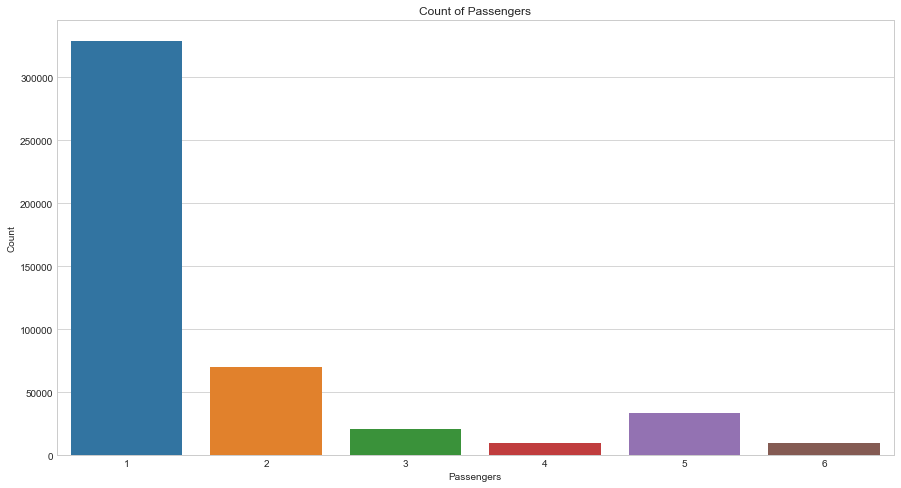

In [123]:
pass_count = nyc.groupby('passenger_count').count()
plt.subplots(figsize=(15,8))
sns.barplot(pass_count.index,pass_count.key)
plt.xlabel('Passengers')
plt.ylabel('Count')
plt.title('Count of Passengers')


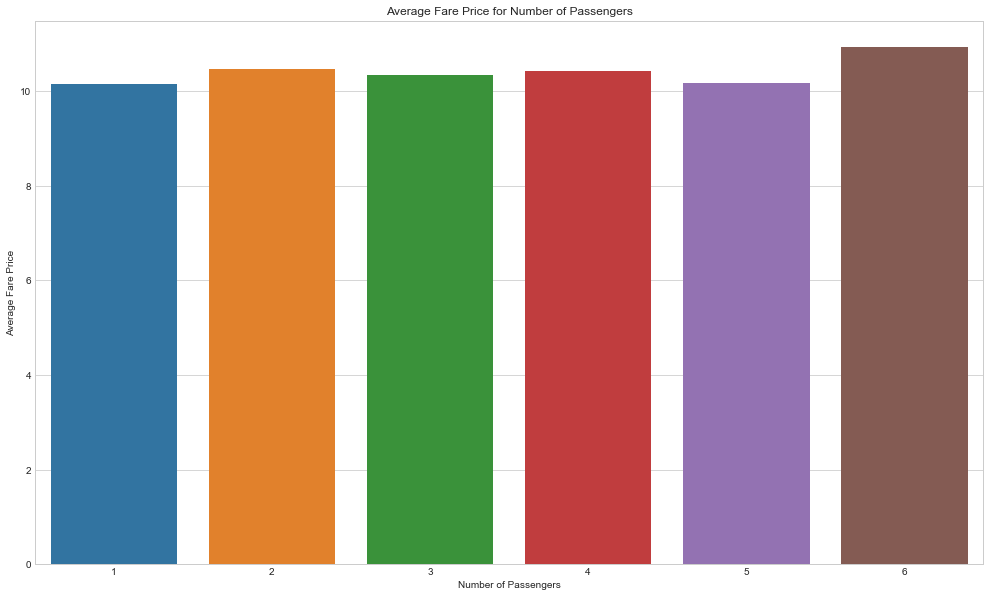

In [124]:
passenger_fare = nyc.groupby(['passenger_count']).mean()

fig, ax = plt.subplots(figsize=(17,10))

sns.barplot(passenger_fare.index, passenger_fare['fare_amount'])
plt.xlabel('Number of Passengers')
plt.ylabel('Average Fare Price')
plt.title('Average Fare Price for Number of Passengers')
plt.show()

In [125]:
print("Average ride cost in USD/Mile : {}".format(nyc.fare_amount.sum()/nyc["distance"].sum()))

Average ride cost in USD/Mile : 5.48840775602234


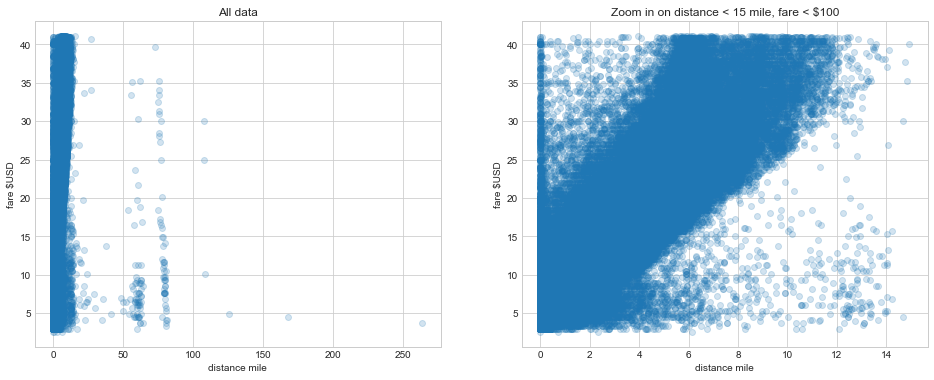

In [126]:
#Scatterplot of distance-Fare

fig, axs = plt.subplots(1, 2, figsize=(16,6))
axs[0].scatter(nyc.distance, nyc.fare_amount, alpha=0.2)
axs[0].set_xlabel('distance mile')
axs[0].set_ylabel('fare $USD')
axs[0].set_title('All data')

# zoom in on part of data
idx = (nyc.distance < 15) 
axs[1].scatter(nyc[idx].distance, nyc[idx].fare_amount, alpha=0.2)
axs[1].set_xlabel('distance mile')
axs[1].set_ylabel('fare $USD')
axs[1].set_title('Zoom in on distance < 15 mile, fare < $100');

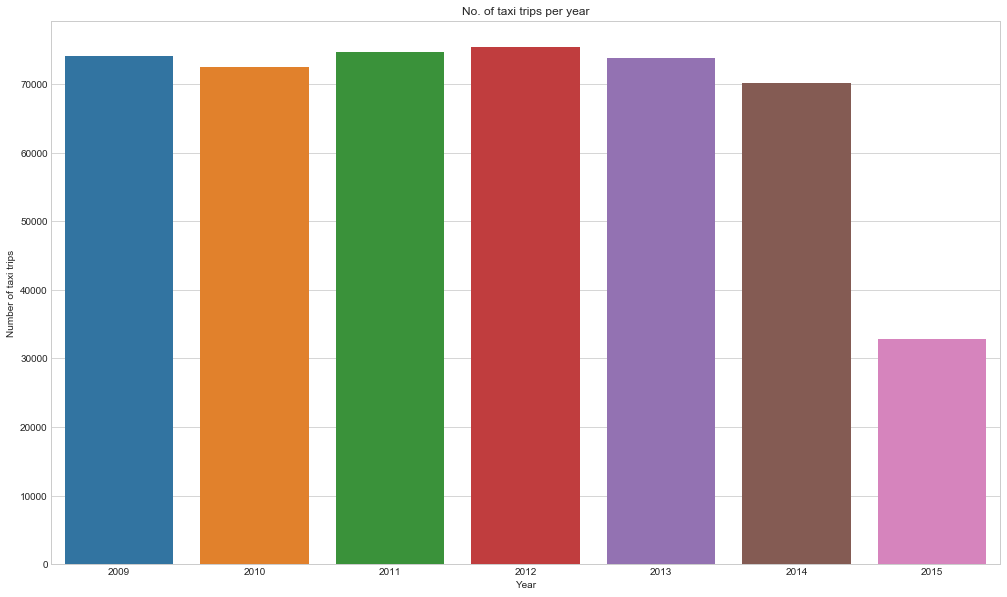

In [127]:
fig, ax = plt.subplots(figsize=(17,10))
year_count = nyc.groupby('year').count()
sns.barplot(year_count.index,year_count.key)
plt.xlabel('Year')
plt.ylabel('Number of taxi trips')
plt.title('No. of taxi trips per year')
plt.show()

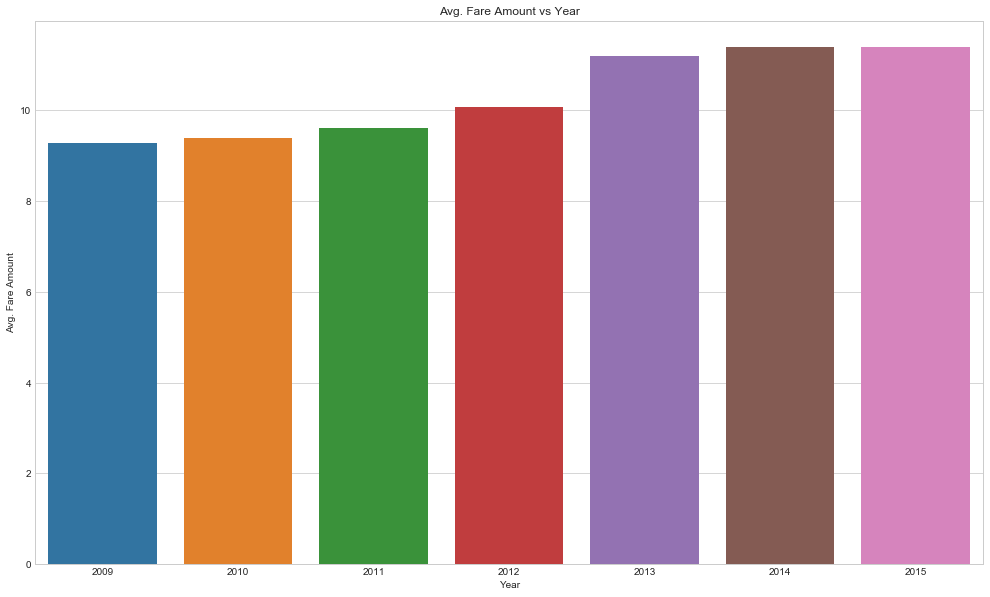

In [152]:
fig, ax = plt.subplots(figsize=(17,10))
avg_fare_years = nyc.groupby('year').mean()
avg_fare_years.head()
sns.barplot(avg_fare_years.index,avg_fare_years.fare_amount)
plt.xlabel('Year')
plt.ylabel('Avg. Fare Amount')
plt.title('Avg. Fare Amount vs Year')
plt.show()

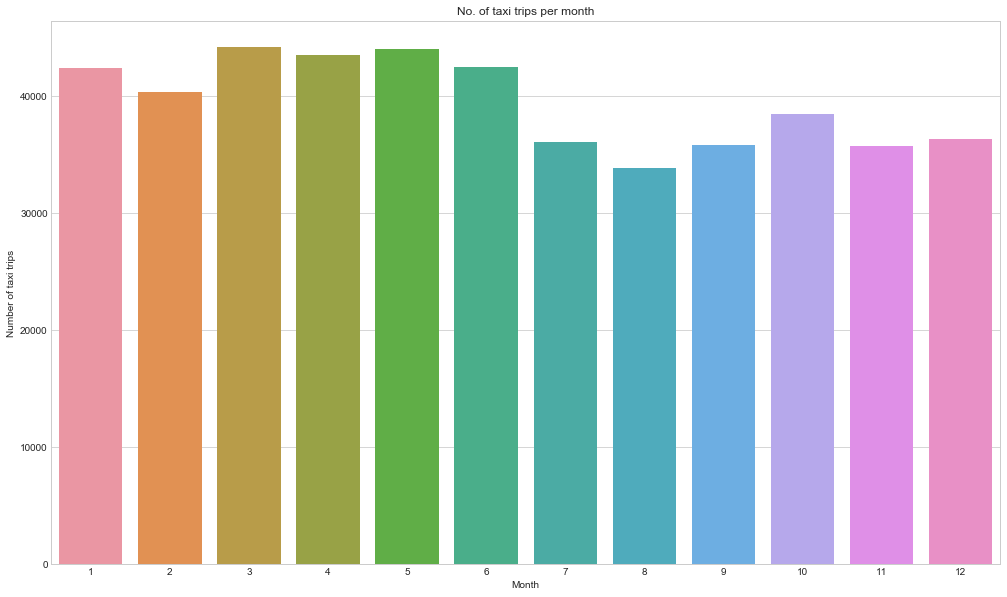

In [128]:
fig, ax = plt.subplots(figsize=(17,10))
month_count = nyc.groupby('month').count()
sns.barplot(month_count.index,month_count.key)
plt.xlabel('Month')
plt.ylabel('Number of taxi trips')
plt.title('No. of taxi trips per month')
plt.show()

### Plot Heatmap of Pickups and Dropoffs within NYC


/Users/ashwinjohnchempolil/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/core.py:420: FutureWarning:

Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.



(-74.03, -73.75)

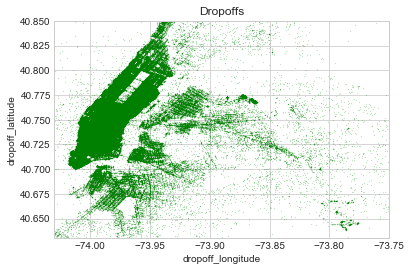

In [133]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
nyc.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

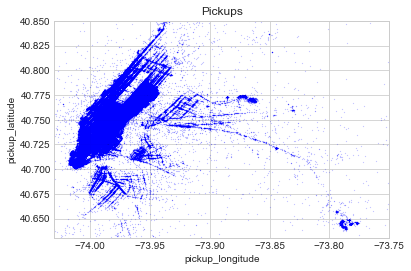

In [134]:
nyc.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

New York city is divided into 7 Boroughs. Let us calculate which borough pickup and dropoff points are. And whether that effects the fare

In [135]:
nyc_boroughs={
    'manhattan':{
        'min_lng':-74.0479,
        'min_lat':40.6829,
        'max_lng':-73.9067,
        'max_lat':40.8820
    },
    
    'queens':{
        'min_lng':-73.9630,
        'min_lat':40.5431,
        'max_lng':-73.7004,
        'max_lat':40.8007

    },

    'brooklyn':{
        'min_lng':-74.0421,
        'min_lat':40.5707,
        'max_lng':-73.8334,
        'max_lat':40.7395

    },

    'bronx':{
        'min_lng':-73.9339,
        'min_lat':40.7855,
        'max_lng':-73.7654,
        'max_lat':40.9176

    },

    'staten_island':{
        'min_lng':-74.2558,
        'min_lat':40.4960,
        'max_lng':-74.0522,
        'max_lat':40.6490

    }
    
    
    
}



In [136]:
def getBorough(lat,lng):
    
    locs=nyc_boroughs.keys()
    for loc in locs:
        if lat>=nyc_boroughs[loc]['min_lat'] and lat<=nyc_boroughs[loc]['max_lat'] and lng>=nyc_boroughs[loc]['min_lng'] and lng<=nyc_boroughs[loc]['max_lng']:
            return loc
    return 'others'

In [137]:
nyc['pickup_borough']=nyc.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
nyc['dropoff_borough']=nyc.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

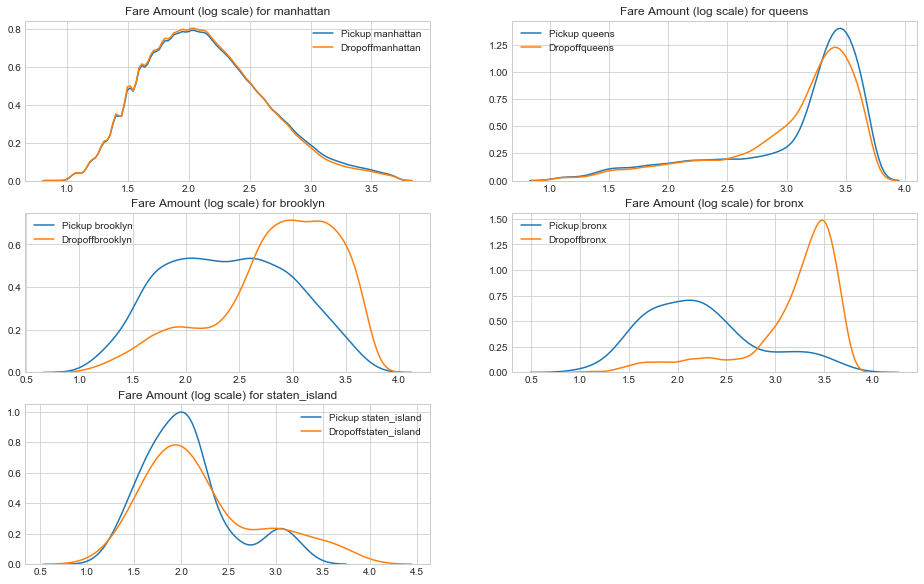

In [138]:
plt.figure(figsize=(16,10))
plt.title("Distribution of Fare Amount Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(nyc.loc[nyc['pickup_borough']==key,'fare_amount'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(nyc.loc[nyc['dropoff_borough']==key,'fare_amount'].values),label='Dropoff'+ key).set_title("Fare Amount (log scale) for "+key)
    
    i=i+1

There is a significant difference in pickups and dropoffs fare amount for each burough except Manhattan. We can see pickups from Queens is expensive compared to pickups from other Buroughs.Very high difference in pickup and dropoff prices for Staten Island.

/Users/ashwinjohnchempolil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning:

divide by zero encountered in log

/Users/ashwinjohnchempolil/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning:

divide by zero encountered in log



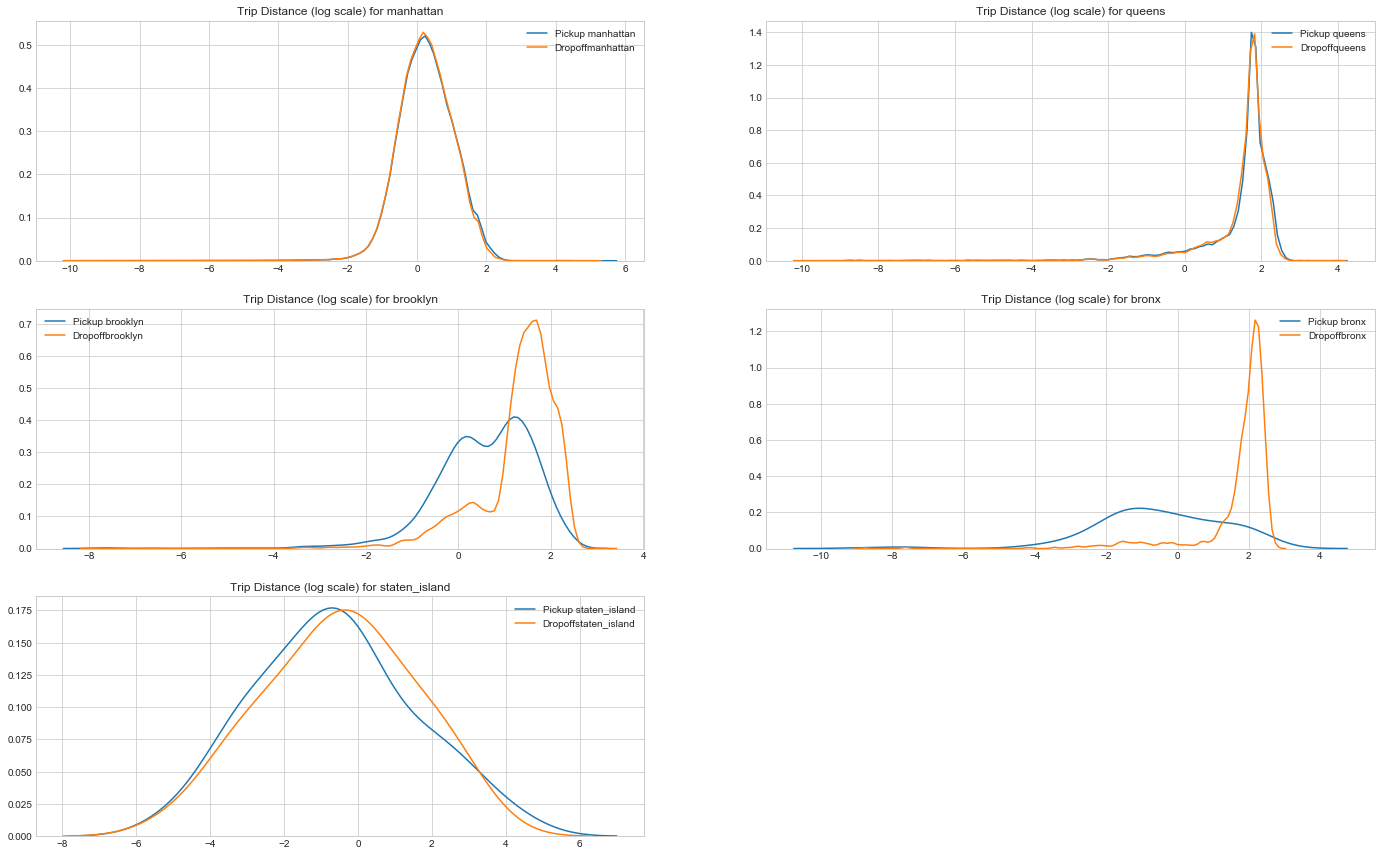

In [139]:
plt.figure(figsize=(24,15))
plt.title("Distribution of Trip Distances Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(nyc.loc[nyc['pickup_borough']==key,'distance'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(nyc.loc[nyc['dropoff_borough']==key,'distance'].values),label='Dropoff'+ key).set_title("Trip Distance (log scale) for "+key)
    i=i+1

Dropoffs to Bronx and Staten island are long trips. 